In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/board-games/bgg_dataset.csv


# <p style="background-color:#615154;font-family:newtimeroman;color:#CABFC1;font-size:150%;text-align:center;border-radius:40px 40px;">BOARD GAMES ANALYSIS</p>

<img src="https://github.com/KarnikaKapoor/Files/blob/main/BoardGames1.gif?raw=true">


<p style="font-family:newtimeroman;color:#615154;font-size:150%;text-align:left;border-radius:40px 40px;">In this project, I will be performing a supervised prediction of Average Ratings on the board games data from the BoardGameGeek database. As the Average Rating comprises continuous values, I will be using the regression model.  I will employ a pipeline to find the best-fitted model. 
I will then draw predictions on the test set using the best model.</p>


   <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#615154;font-family:newtimeroman;color:#CABFC1;font-size:150%;text-align:center;border-radius:40px 40px;">TABLE OF CONTENTS</p>   
    
* [1. IMPORTING LIBRARIES](#1)
    
* [2. LOADING DATA](#2)
    
* [3. DATA CLEANING](#3)
    
* [4. DATA EXPLORATION](#4)   
    
* [5. DATA PREPROCESSING](#5) 
      
* [6. MODEL SELECTION](#6)
    
* [7. EVALUATING MODELS](#7)
 
* [8. CONCLUSION](#8)

<a id="1"></a>
# <p style="background-color:#615154;font-family:newtimeroman;color:#CABFC1;font-size:150%;text-align:center;border-radius:40px 40px;">IMPORTING LIBRARIES</p>    


In [2]:
#Importing the Libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")
    
np.random.seed(42)

<a id="2"></a>
# <p style="background-color:#615154;font-family:newtimeroman;color:#CABFC1;font-size:150%;text-align:center;border-radius:40px 40px;">LOADING DATA</p>

In [3]:
#Loading the dataset
data = pd.read_csv("../input/board-games/bgg_dataset.csv", sep=";")
print("Number of datapoints:", len(data))
data.head(3)

Number of datapoints: 20343


,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,174430.0,Gloomhaven,2017.0,1,4,120,14,42055,"8,79",1,"3,86",68323.0,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,161936.0,Pandemic Legacy: Season 1,2015.0,2,4,60,13,41643,"8,61",2,"2,84",65294.0,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"
2,224517.0,Brass: Birmingham,2018.0,2,4,120,14,19217,"8,66",3,"3,91",28785.0,"Hand Management, Income, Loans, Market, Networ...",Strategy Games


<img src="https://github.com/KarnikaKapoor/Files/blob/main/BoardGames2.png?raw=true">


<a id="3"></a>
# <p style="background-color:#615154;font-family:newtimeroman;color:#CABFC1;font-size:150%;text-align:center;border-radius:40px 40px;">DATA CLEANING</p>

**In this section, I will be performing:** 
* Data Cleaning
* Feature Engineering 

In [4]:
#Information on features 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20343 entries, 0 to 20342
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  20327 non-null  float64
 1   Name                20343 non-null  object 
 2   Year Published      20342 non-null  float64
 3   Min Players         20343 non-null  int64  
 4   Max Players         20343 non-null  int64  
 5   Play Time           20343 non-null  int64  
 6   Min Age             20343 non-null  int64  
 7   Users Rated         20343 non-null  int64  
 8   Rating Average      20343 non-null  object 
 9   BGG Rank            20343 non-null  int64  
 10  Complexity Average  20343 non-null  object 
 11  Owned Users         20320 non-null  float64
 12  Mechanics           18745 non-null  object 
 13  Domains             10184 non-null  object 
dtypes: float64(3), int64(6), object(5)
memory usage: 2.2+ MB


**From the above info, it can be deduced that:**
* Year published is not parsed as a DateTime object, but we can work with that. 
* The Rating Average and Complexity Average are saved as object data types. On further inspection, it can be concluded the decimal is misplaced as a comma. 
* There are some missing values  
* Mechanics and Domains are object data types and need further exploration

**Let us handle the "Year Published" feature first of all** 

In [5]:
#let's explore Year Published
print("Oldest game in the data was published in:", min(data["Year Published"]))
print("Latest game in the data was published in:", max(data["Year Published"]))

Oldest game in the data was published in: -3500.0
Latest game in the data was published in: 2022.0


**The oldest game is quite old! I must see what game is it.** 

In [6]:
#having a look at the NA rows
Oldest = np.where(data["Year Published"]==min(data["Year Published"]))
print("Oldest games in dataset")
data.iloc[Oldest].style.set_properties(**{"background-color": "#CABFC1","color": "#615154", "border-color": "#615154"})

Oldest games in dataset


,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
8174,2399.000000,Senet,-3500.000000,2,2,30,6,664,"5,82",8176,"1,48",1343.000000,"Dice Rolling, Roll / Spin and Move",Abstract Games


<p style="background-color:#CABFC1;font-family:newtimeroman;font-size:120%;text-align:left;"> 📌**Oldest Game In The Dataset Is Senet:** Senet is a board game from ancient Egypt. The earliest representation of senet is dated to 2620 BCE from the Mastaba of Hesy-Re, while similar boards and hieroglyphic signs are found even earlier.</p>

**Finding are some other old games**

In [7]:
print("Oldest games in dataset:")
data.nsmallest(5,["Year Published"]).style.set_properties(**{"background-color": "#CABFC1","color": "#615154", "border-color": "#615154"})

Oldest games in dataset:


,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
8174,2399.000000,Senet,-3500.000000,2,2,30,6,664,"5,82",8176,"1,48",1343.000000,"Dice Rolling, Roll / Spin and Move",Abstract Games
1275,2397.000000,Backgammon,-3000.000000,2,2,30,8,11680,"6,54",1276,"2,02",17747.000000,"Advantage Token, Betting and Bluffing, Dice Rolling, Roll / Spin and Move, Track Movement",Abstract Games
20219,5546.000000,Marbles,-3000.000000,1,0,10,4,473,"4,69",20221,"1,10",399.000000,Flicking,Children's Games
8924,1602.000000,The Royal Game of Ur,-2600.000000,2,2,30,10,549,"5,90",8926,"1,31",1162.000000,"Dice Rolling, Roll / Spin and Move, Square Grid, Static Capture",Abstract Games
172,188.000000,Go,-2200.000000,2,2,180,8,14843,"7,64",173,"4,00",20398.000000,"Enclosure, Square Grid",Abstract Games


In the next cell I will:
* Drop the NA values for Owned Users.
* Create a new feature **Game Age** out of  **Year Published**
* Replace the comma in the **Rating Average** and **Complexity Average** with a decimal 

In [8]:
#Dropping NA
data = data[data["Owned Users"].notna()]

#Getting the age of game from year published for simplicity 
data["Game Age"] =  2022-data["Year Published"]

#A function to replace the comma with a decimal 
def Fix_Decimal(data):
    fixed_values=[]
    for i in data:
        i = i.replace(",",".")
        fixed_values.append(i)
    return fixed_values
#Applying the "Fix_decimal" function to the features
data["Rating Average"] =  pd.to_numeric(Fix_Decimal(data["Rating Average"]))
data["Complexity Average"] =  pd.to_numeric(Fix_Decimal(data["Complexity Average"]))

Next exploring columns that have missing values

In [9]:
print("Columns with missing values:", data.columns[data.isnull().any()])

Columns with missing values: Index(['Mechanics', 'Domains'], dtype='object')


As Mechanics and Domains hold text separated by a comma, for these features NA is a bit fishy so I will look at some of the NA rows. 

In [10]:
#The NA rows in Mechanics
NAs = np.where(data["Mechanics"].isna())
print("First three NA values in Mechanics:")
data.iloc[NAs][:3].style.set_properties(**{"background-color": "#CABFC1","color": "#615154", "border-color": "#615154"})

First three NA values in Mechanics:


,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains,Game Age
1059,85256.000000,Timeline: Inventions,2010.000000,2,8,15,8,7257,6.710000,1060,1.110000,12448.000000,nan,Family Games,12.000000
1150,113401.000000,Timeline: Events,2011.000000,2,8,15,8,4208,6.780000,1151,1.100000,7924.000000,nan,"Family Games, Party Games",11.000000
1216,131325.000000,Timeline: Diversity,2012.000000,2,8,15,8,3790,6.790000,1217,1.070000,7589.000000,nan,"Family Games, Party Games",10.000000


In [11]:
#The NA rows in Domains 
NANs = np.where(data["Domains"].isna())
print("First three NA values in Domains:")
data.iloc[NANs][:3].style.set_properties(**{"background-color": "#CABFC1","color": "#615154", "border-color": "#615154"})

First three NA values in Domains:


,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains,Game Age
663,293141.000000,King of Tokyo: Dark Edition,2020.000000,2,6,30,8,1854,7.890000,664,1.630000,5157.000000,"Card Drafting, Dice Rolling, King of the Hill, Player Elimination, Push Your Luck",nan,2.000000
1011,177802.000000,Smash Up: It's Your Fault!,2016.000000,2,2,60,14,1663,7.530000,1012,2.060000,6347.000000,"Area Majority / Influence, Hand Management, Take That, Variable Phase Order",nan,6.000000
1047,226520.000000,Exit: The Game - The Sinister Mansion,2018.000000,1,4,90,12,1595,7.450000,1048,2.610000,3446.000000,Cooperative Game,nan,4.000000


I have decided to add new values for NA in the Mechanics and Domains 
- For Mechanics as "Not Mentioned"
- for Domains as "Basic"

In [12]:
#Replacing NA values
data["Mechanics"] = data["Mechanics"].fillna("Not Mentioned")
data["Domains"] = data["Domains"].fillna("Basic")

**Some observations to be noted concerning Mechanics and Domains:**
* It contains a list of strings of values
* values are separated by either a "," or a "/" 
* There could be more rare characters

To eliminate these issues I will be cleaning the text and forming a tokenized value.


In [13]:
#Defining a function to clean up the text 
def Clean(Text):
    sms = re.sub('[^a-zA-Z], ,', ' ', str(Text)) 
    sms = sms.replace("/",",")
    sms = sms.split()
    sms = ' '.join(sms)
    return sms
data["Mechanics"] = data["Mechanics"].apply(Clean)
data["Domains"] = data["Domains"].apply(Clean)

print("First three values of Mechanics after cleaning text:")
print(data["Mechanics"][:3], "\n")

print("First three values of Domains after cleaning text:")
print(data["Domains"][:3])


First three values of Mechanics after cleaning text:
0    Action Queue, Action Retrieval, Campaign , Bat...
1    Action Points, Cooperative Game, Hand Manageme...
2    Hand Management, Income, Loans, Market, Networ...
Name: Mechanics, dtype: object 

First three values of Domains after cleaning text:
0    Strategy Games, Thematic Games
1    Strategy Games, Thematic Games
2                    Strategy Games
Name: Domains, dtype: object


**The data we will be working with here on**

In [14]:
#Dropping the redundant features
data = data.drop(["ID", "Name", "Year Published"], axis=1) 
#Setting up prefrences
sns.set(rc={"axes.facecolor":"#FCE4DE","figure.facecolor":"#CABFC1"})
cmap = colors.ListedColormap(["#615154", "#F7B4A7", "#94DDDE", "#DCFFF5", "#F0ABC1"])
palette = ["#615154", "#F7B4A7", "#94DDDE", "#FCE4DE", "#DCFFF5", "#F0ABC1", "#CABFC1"]
#data.head(3).style.set_properties(**{"background-color": "#CABFC1","color": "#615154", "border-color": "#615154"})

The data is quite clean and the new feature has been included. I will proceed to the next step. That is, exploring the data. 

<a id="4"></a>
# <p style="background-color:#615154;font-family:newtimeroman;color:#CABFC1;font-size:150%;text-align:center;border-radius:40px 40px;">DATA EXPLORATION</p>

In this section, 

Exploring data for outliers


* Exploring the Mechanics attribute
* Exploring the Domains attribute


**Let us start with pairplot**

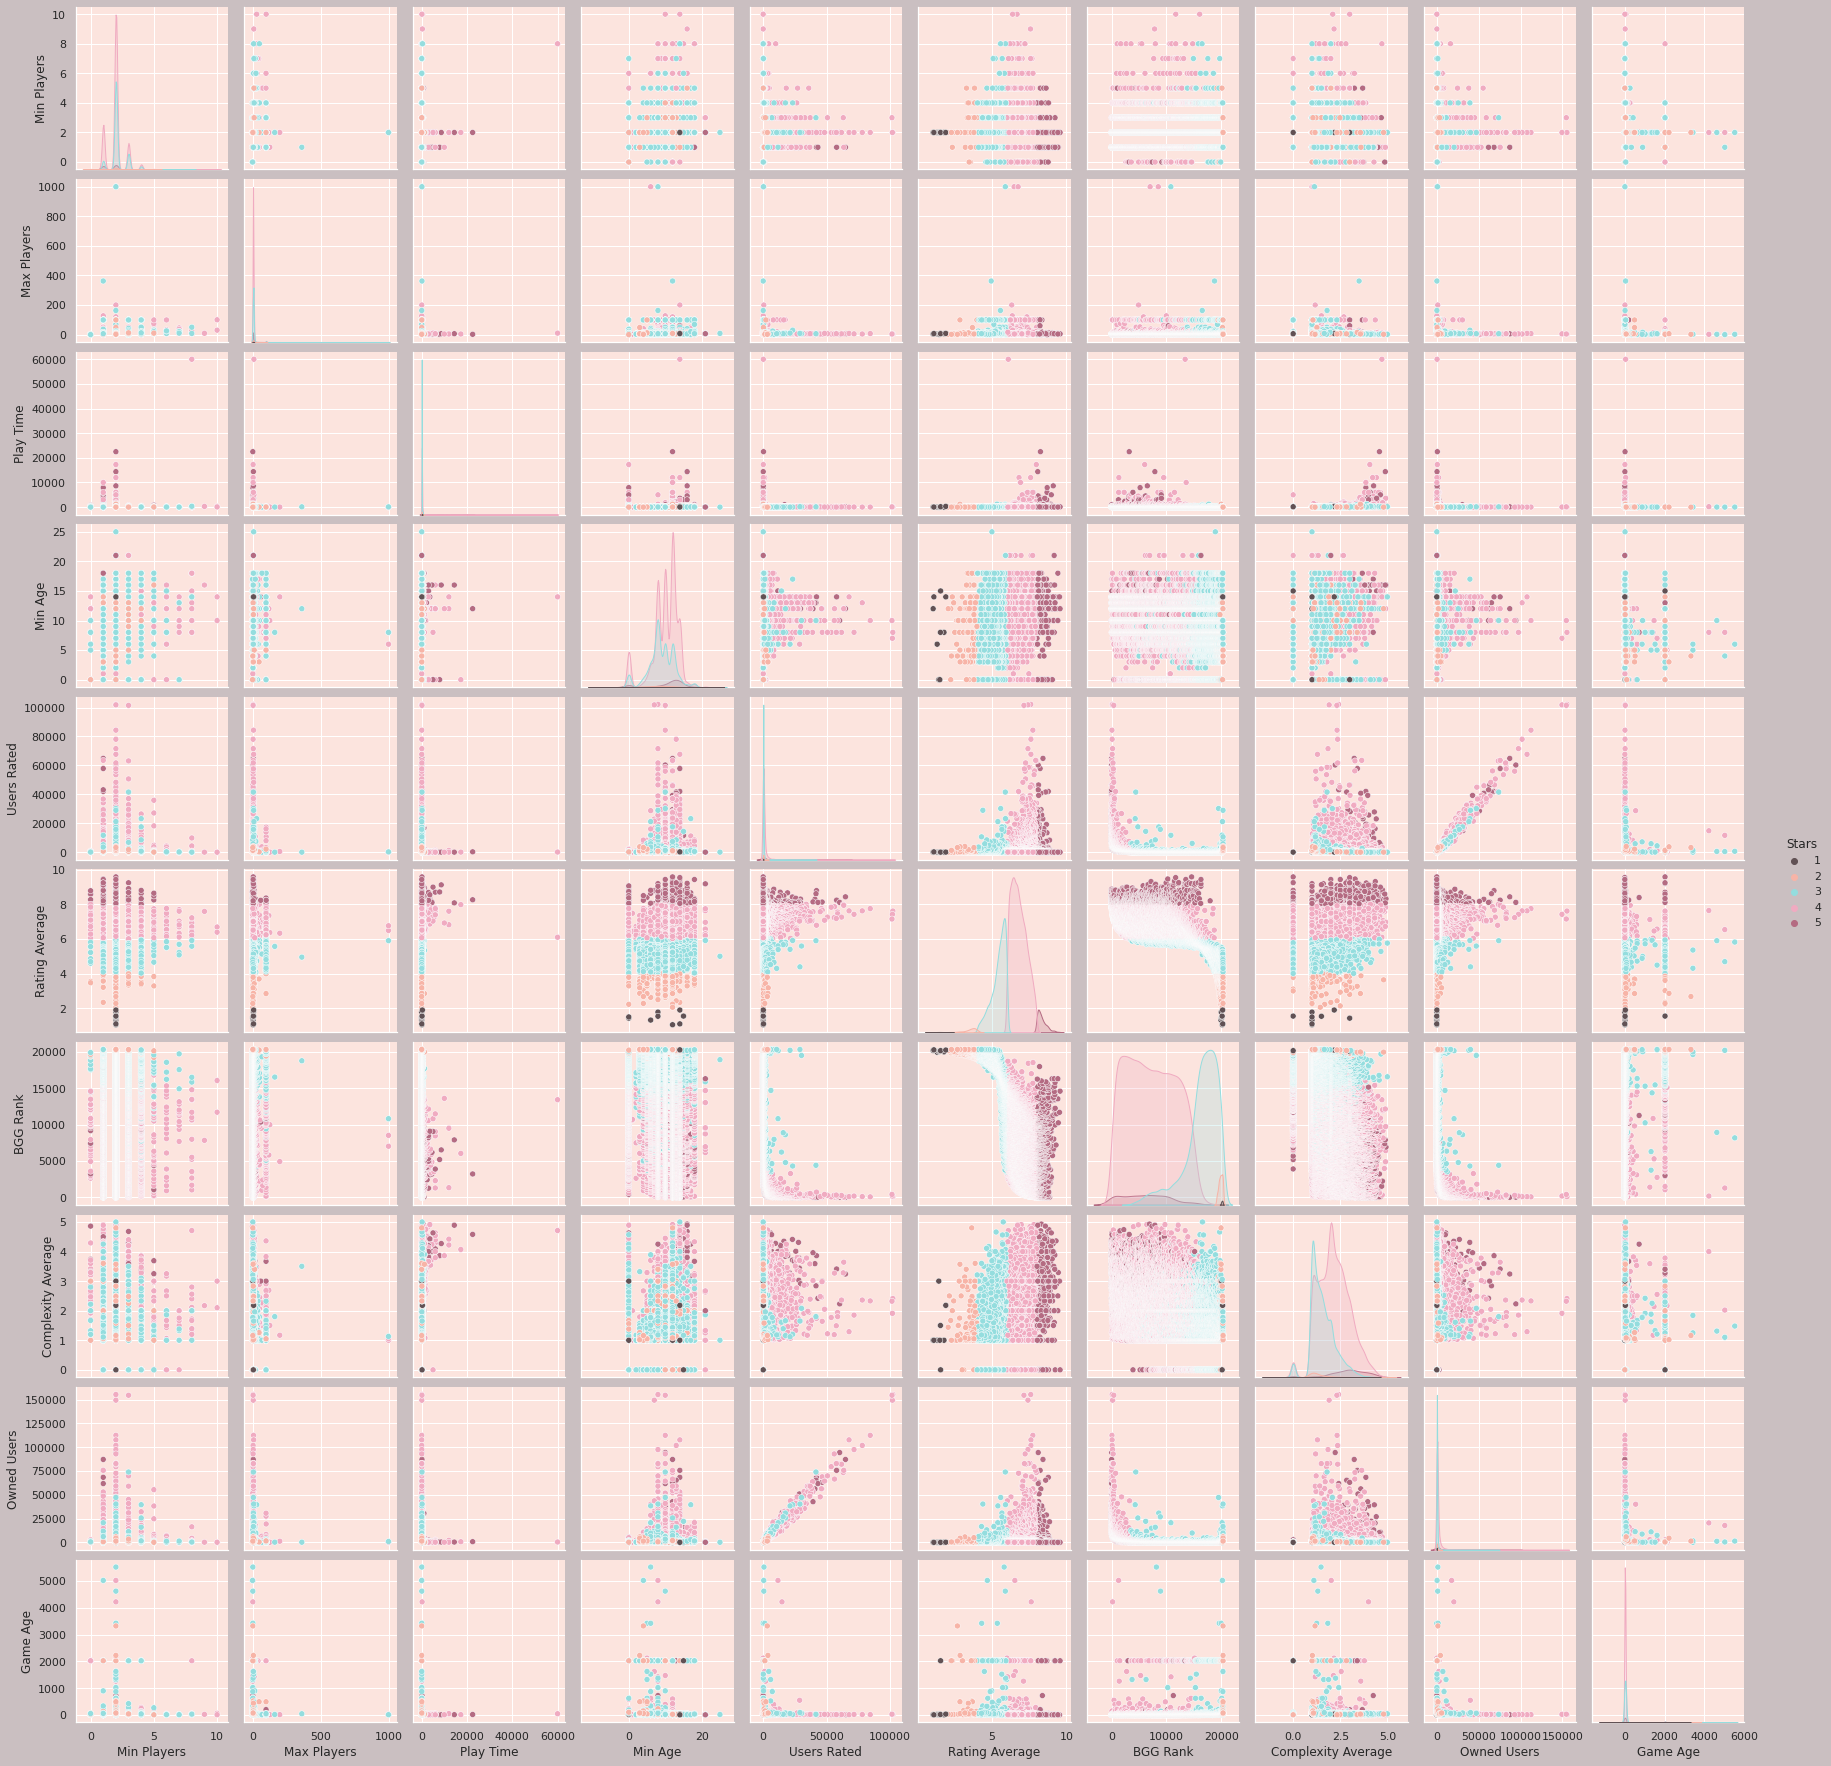

In [15]:
#Creating Five stars based bins
bins = [0, 2, 4, 6, 8, 10]
labels = [1,2,3,4,5]
data["Stars"] = pd.cut(data["Rating Average"], bins=bins, labels=labels)
#Pairplot 
hue_C = ["#615154", "#F7B4A7", "#94DDDE", "#F0ABC1", "#B46B82"]
sns.pairplot(data,hue= "Stars", palette= hue_C)

There are some outliers. So I have examined those up close for anomaly detection.
After some inspection, I have decided to be lenient with outliers so I will put a cap only to drop off some obvious anomalies. 

In [16]:
#Dropping the outliers. 
data = data[(data["Max Players"]<300)]
data = data[(data["Play Time"]<30000)]
data = data[(data["Min Age"]<22)]
data = data[(data["Users Rated"]<100000)]
data.shape

(20311, 13)

Now let's have a closer look at the data

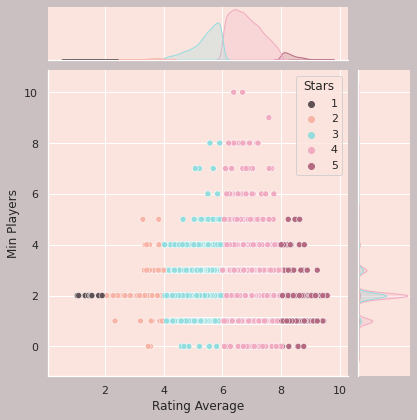

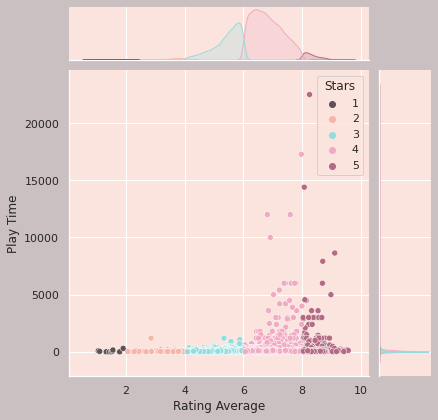

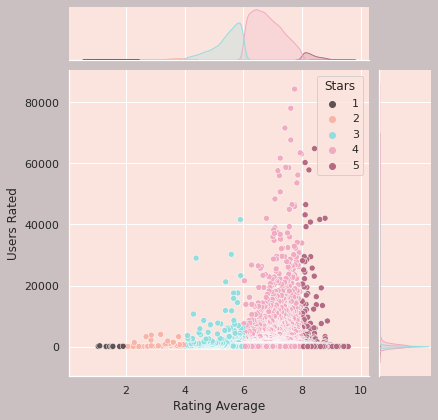

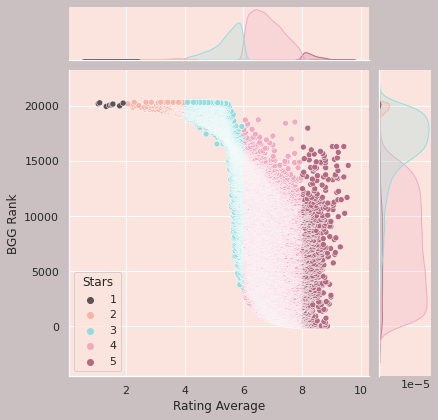

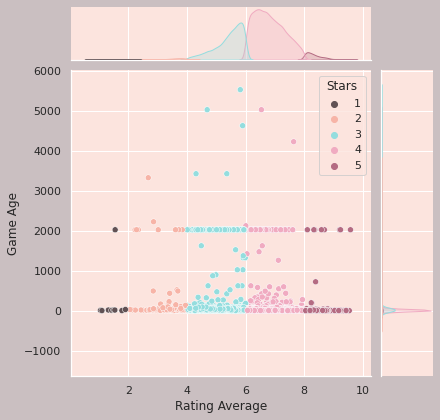

In [17]:
To_plot = ["Min Players","Play Time", "Users Rated","BGG Rank", "Game Age"]
for i in To_plot:
    sns.jointplot(x=data["Rating Average"], y=data[i], hue=data["Stars"], palette= hue_C, )
    plt.show()

<p style="background-color:#CABFC1;font-family:newtimeroman;font-size:120%;text-align:left;"> 📌Some Takeaways</p>

* The best-rated games (with 8+ ratings) need five or fewer min players. 
* Ratings have a correlation with Playtime as expected. People give a good rating of the game they like to play. 
* In general people care to vote if they like a game and don't bother voting if they don't like it. 
* BGG Rankings are in accordance with the Average ratings.  

Up next I will plot the classic correlation matrix with a few significant columns. 

*Note: we still have some columns in object dtype that we will be exploring ahead*

<AxesSubplot:>

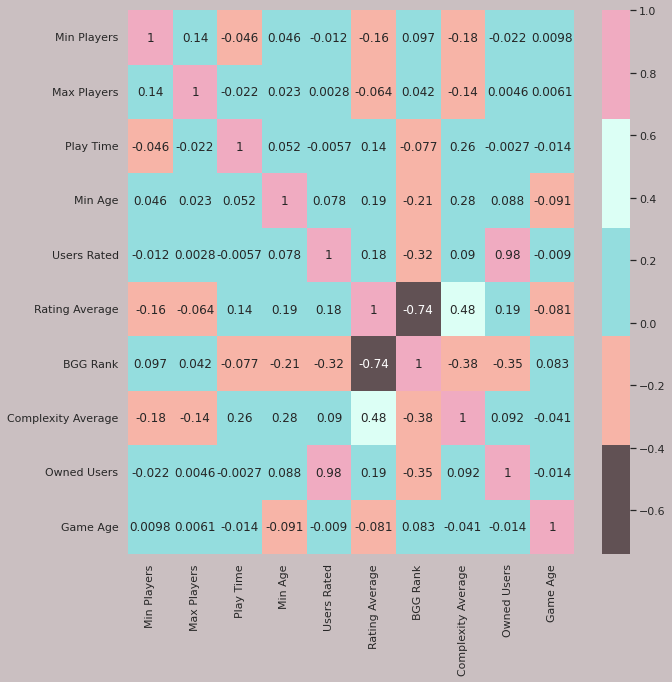

In [18]:
#correlation matrix
corrmat= data.corr()
plt.figure(figsize=(10,10))  
sns.heatmap(corrmat,annot=True, cmap=cmap)

Now we get to Explore the columns with the Object dtypes. 
**Mechanics** and **Domains**

First of all, A functun to extract content out of the said features

In [19]:
#Code to get Corpus
def Get_Corpus(bla):
    corpus= []
    for i in bla:
        item = i.split(",")
        corpus += item
    return corpus
#Code to delete extra space
def space_eleminator(list):
    vals=[]
    for i in list:
        m = i.lstrip()
        vals.append(m)
    return vals

Mechanics_corpus = space_eleminator(Get_Corpus(data["Mechanics"]))
Domains_corpus = space_eleminator(Get_Corpus(data["Domains"]))
print("First 5 tokens in the Mechanics features:\n", Mechanics_corpus[:5])
print("First 5 tokens in the Domains features:\n", Domains_corpus[:5], "\n")


First 5 tokens in the Mechanics features:
 ['Action Queue', 'Action Retrieval', 'Campaign ', 'Battle Card Driven', 'Card Play Conflict Resolution']
First 5 tokens in the Domains features:
 ['Strategy Games', 'Thematic Games', 'Strategy Games', 'Thematic Games', 'Strategy Games'] 



**Exploring the Mechanics attribute**

In [20]:
#Creating a count dictionary for items in Mechanics 
Mechs_dic = Counter(Mechanics_corpus)
#Exploring the The occurence of Mechanincs 
Item_M = list(Mechs_dic.keys())
Freq_M = list(Mechs_dic.values())

print("Number of unique items in Machanics:", len(Mechs_dic))
print("Most frequently used Mechanics appeared:", max(Freq_M), "times")
print("Least frequently used Mechanics appeared:", min(Freq_M), "time")

Number of unique items in Machanics: 195
Most frequently used Mechanics appeared: 5667 times
Least frequently used Mechanics appeared: 1 time


Scatter Plot for the usage of Mechanics

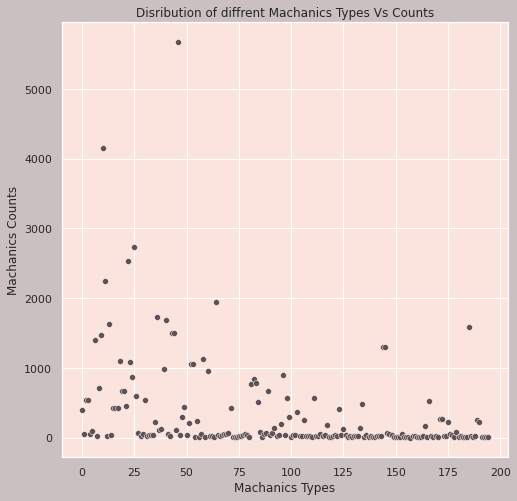

In [21]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=Item_M, y=Freq_M, color= palette[0])
plt.title("Disribution of diffrent Machanics Types Vs Counts")
plt.xlabel("Machanics Types")
plt.ylabel("Machanics Counts")
plt.xscale("linear")
plt.show()

In [22]:
print("Five most frequently used Mechanics:")
print(sorted(Mechs_dic, key=Mechs_dic.get, reverse=True)[:5])

Five most frequently used Mechanics:
['Dice Rolling', 'Hand Management', 'Set Collection', 'Variable Player Powers', 'Hexagon Grid']


In [23]:
print("Five rarely used Mechanics:")
print(sorted(Mechs_dic, key=Mechs_dic.get, reverse=True)[-6:-1])

Five rarely used Mechanics:
['Order Counters', 'Passed Action Token', 'Selection Order Bid', 'Auction: Dutch Priority', 'Auction: Dexterity']


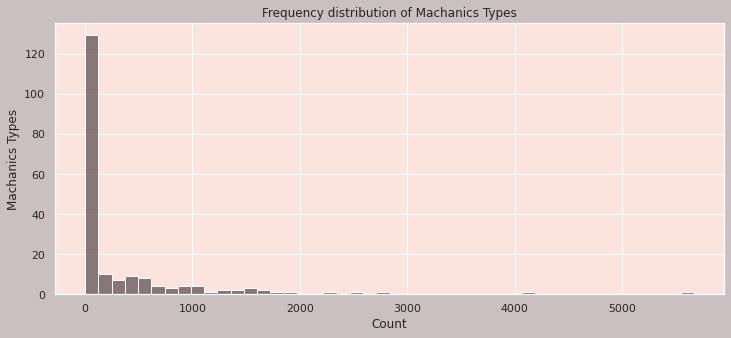

In [24]:
# Plotting the distribution of Mechanics types
plt.figure(figsize=(12,5))
sns.histplot(Mechs_dic, color=palette[0])
plt.title("Frequency distribution of Machanics Types")
plt.xlabel("Count")
plt.ylabel("Machanics Types")
plt.show()

<p style="background-color:#CABFC1;font-family:newtimeroman;font-size:120%;text-align:left;"> 📌Mechanics have a total of 195 unique types.
    📌The most frequently used Mechanics is Dice Rolling</p>


**Exploring the Domains attribute**

In [25]:
#Creating a count dictionary for items in Mechanics 
Dom_dic = Counter(Domains_corpus)
#Exploring the The occurence of Mechanincs 
Item_D = list(Dom_dic.keys())
Freq_D = list(Dom_dic.values())

print("Number of unique items in Domains:", len(Dom_dic))
print("Most Abundant Domain:", max(Freq_D), "times")
print("Most Common Domain:", min(Freq_D), "time")

Number of unique items in Domains: 9
Most Abundant Domain: 10132 times
Most Common Domain: 297 time


In [26]:
print("List of Domains: \n")
Item_D

List of Domains: 



['Strategy Games',
 'Thematic Games',
 'Wargames',
 'Family Games',
 'Customizable Games',
 'Abstract Games',
 'Party Games',
 "Children's Games",
 'Basic']

In [27]:
print("Five most frequently Domains:")
print(sorted(Dom_dic, key=Dom_dic.get, reverse=True)[:5])

Five most frequently Domains:
['Basic', 'Wargames', 'Strategy Games', 'Family Games', 'Thematic Games']


In [28]:
print("Three rare Domains:")
print(sorted(Dom_dic, key=Dom_dic.get, reverse=True)[-4:-1])

Three rare Domains:
['Abstract Games', "Children's Games", 'Party Games']


Distribution of various Domains

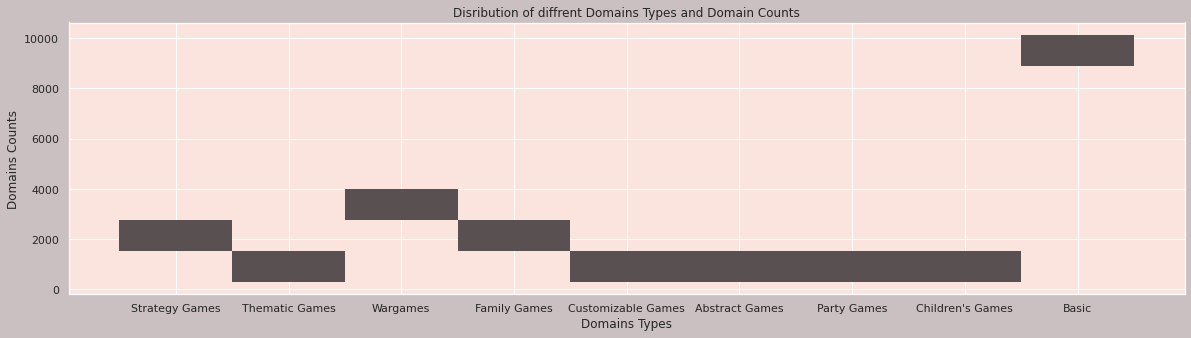

In [29]:
plt.figure(figsize=(20,5))
sns.histplot(x=Item_D, y=Freq_D, color= palette[0])
plt.title("Disribution of diffrent Domains Types and Domain Counts")
plt.xlabel("Domains Types")
plt.ylabel("Domains Counts")
plt.show()

<p style="background-color:#CABFC1;font-family:newtimeroman;font-size:120%;text-align:left;"> 📌There are a total of eight Domains. Excluding Basic, it is indicative of NA values
📌The most Common Domain is War Games followed by Strategy Games and Family Games</p>

<a id="5"></a>
# <p style="background-color:#615154;font-family:newtimeroman;color:#CABFC1;font-size:150%;text-align:center;border-radius:40px 40px;">DATA PREPROCESSING</p>

At this step, I will be dealing with the object type variables Mechanics and Domains. I have decided to One Hot Encoded (OHE) these variables such that each of the individual attributes in the given cell gets its own column. 

**The following steps are involved:**
* Building dummies for the said columns 
* Dropping one of the columns created to avoid dummy variable trap
* Tiding up the column names because why not 
* Concatenating the OHE columns data frames with the main data frame
* Assigning labels and targets 
* Lastly, splitting the test and training sets

**Creating dummy variables**

In [30]:
#Creating dummy variables for Mechanics
Mechanics_df = data["Mechanics"].str.get_dummies(",")
Mechanics_df = Mechanics_df.drop(Mechanics_df.columns[-1], axis= 1) #to avoid dummy variable trap
#Creating dummy variables for Domains
Domains_df = data["Domains"].str.get_dummies(",")
Domains_df = Domains_df.drop(Domains_df.columns[-1], axis= 1) #to avoid dummy variable trap

#Clearing up the extra space in the column names (optional)
DFs = [Mechanics_df, Domains_df]
for i in DFs:
    i.columns= [col.strip() for col in i.columns]

**Concatenate the dummy variables to the main dataframe**

In [31]:
data = data.drop(["Mechanics", "Domains", "Stars"], axis=1) #Stars is basically ratings 
data = pd.concat([data,Mechanics_df ,Domains_df],axis= 1)
data.head()

,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Game Age,...,Thematic Games,Wargames,Abstract Games,Basic,Children's Games,Customizable Games,Family Games,Party Games,Strategy Games,Thematic Games
0,1,4,120,14,42055,8.79,1,3.86,68323.0,5.0,...,1,0,0,0,0,0,0,0,1,0
1,2,4,60,13,41643,8.61,2,2.84,65294.0,7.0,...,1,0,0,0,0,0,0,0,1,0
2,2,4,120,14,19217,8.66,3,3.91,28785.0,4.0,...,0,0,0,0,0,0,0,0,1,0
3,1,5,120,12,64864,8.43,4,3.24,87099.0,6.0,...,0,0,0,0,0,0,0,0,1,0
4,3,6,480,14,13468,8.70,5,4.22,16831.0,5.0,...,1,0,0,0,0,0,0,0,1,0


**Assigning labels and targets** 

In [32]:
# Assigning the featurs as X and trarget as y
X= data.drop(["Rating Average"],axis =1)
y= data["Rating Average"]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=7)

<a id="6"></a>
# <p style="background-color:#615154;font-family:newtimeroman;color:#CABFC1;font-size:150%;text-align:center;border-radius:40px 40px;">MODEL SELECTION</p>

For model selection, I will be building pipelines of five different regressors and select one with the best cross-validation results. 

**In this section:**

* The model pipelines with preprocessing: (Standard Scaler and PCA)
* Fitting the training set to the various models
* Getting the cross-validation results 
* Picking the best regressor

**Building the pipelines for and getting the various cross-validation scores**

In [33]:
#Building piplines for model selection

pipeline_lr=Pipeline([("scalar1",StandardScaler()),
                      ("pca1",PCA(n_components=50)),
                      ("LR",LinearRegression())])

pipeline_dt=Pipeline([("scalar2",StandardScaler()),
                      ("pca2",PCA(n_components=50)),
                      ("DT",DecisionTreeRegressor())])

pipeline_rf=Pipeline([("scalar3",StandardScaler()),
                      ("pca3",PCA(n_components=50)),
                      ("RF",RandomForestRegressor())])

pipeline_knn=Pipeline([("scalar4",StandardScaler()),
                       ("pca4",PCA(n_components=50)),
                       ("KN",KNeighborsRegressor())])

pipeline_xgb=Pipeline([("scalar5",StandardScaler()),
                       ("pca4",PCA(n_components=50)),
                       ("XGB",XGBRegressor())])

#List of all the pipelines
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_knn, pipeline_xgb]

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "LinearRegression", 1: "DecisionTree", 2: "RandomForest",3: "KNeighbors", 4: "XGBRegressor"}


# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

#Getting CV scores    
cv_results_rms = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train,y_train,scoring="neg_root_mean_squared_error", cv=10)
    cv_results_rms.append(cv_score)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

LinearRegression: -0.714668 
DecisionTree: -0.906000 
RandomForest: -0.611428 
KNeighbors: -0.673078 
XGBRegressor: -0.633297 


The best model is ... Random Forest 🏆

<a id="7"></a>
# <p style="background-color:#615154;font-family:newtimeroman;color:#CABFC1;font-size:150%;text-align:center;border-radius:40px 40px;">EVALUATING MODELS</p>

As established above, the winner is Random Forest. So now I get the results for the test set to evaluate the model and conclude this notebook. 

**Getting Predictions on the test set**

In [34]:
# Model prediction on test data
pred = pipeline_rf.predict(X_test)
# Model Evaluation
r2 = metrics.r2_score(y_test, pred)
Adjusted_r2 = 1 - (1-metrics.r2_score(y_test, pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
mae = metrics.mean_absolute_error(y_test, pred)
mse = metrics.mean_squared_error(y_test, pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

# initialise data of lists.
ResultData = [[r2],[Adjusted_r2],[mae],[mse],[rmse]]
# Creates pandas DataFrame.
Results = pd.DataFrame(ResultData,columns= ["Scores"] ,index = ["R-Squared","Adjusted R-Squared", "Mean Absolute Error","Mean Square Error","Root Mean Square Error"])
Results.style.background_gradient(cmap=cmap)

,Scores
R-Squared,0.551306
Adjusted R-Squared,0.517675
Mean Absolute Error,0.466932
Mean Square Error,0.407139
Root Mean Square Error,0.638075


<a id="8"></a>
# <p style="background-color:#615154;font-family:newtimeroman;color:#CABFC1;font-size:150%;text-align:center;border-radius:40px 40px;">CONCLUSION</p>

<img src="https://github.com/KarnikaKapoor/Files/blob/main/BoardGames3.png?raw=true">



# <p style="background-color:#615154;font-family:newtimeroman;color:#CABFC1;font-size:150%;text-align:center;border-radius:40px 40px;">END</p>